In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import random
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ast
from sklearn.model_selection import train_test_split

In [2]:
train_images = 'train2014/train2014'
val_images = 'val2014/val2014'
test_images = 'test2015/test2015'
img_width = 448
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [3]:
data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
data.dropna(inplace = True)
val_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [5]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [6]:
data['multiple_choice_answer'] = data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
val_data['multiple_choice_answer'] = val_data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [7]:
X_train = data
X_val = val_data
X_test = test_data

del data, val_data, test_data
len(X_train), len(X_val), len(X_test)

(443749, 214349, 447793)

In [8]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

In [9]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [10]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [11]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (388247, 1000)
Shape of Answer Vectors in Validation Data:  (214349, 1000)


### Question vectors

In [12]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [13]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

In [14]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)

Number of words in tokenizer: 12449
Shape of Question Vectors in Train Data:  (388247, 24)


### Model


In [15]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    img = tf.expand_dims(img, axis=0)
    return img, image_path

def VGG_Top():
    model = tf.keras.applications.VGG19(include_top = False,
                                            weights="imagenet",
                                            input_shape = (img_width, img_height,3))
    
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

In [16]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 256
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+2

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 256 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [17]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)
    return model

In [18]:
def generate_on_test(model):
    random.seed(42)
    test_idx = np.random.randint(len(X_val), size = 20)
    model_vgg = VGG_Top()
    k = 5

    for idx in test_idx:
        test_image_id = X_test['image_id'].values[idx]
        test_question = X_test['question'].values[idx]
        test_image_path = test_images + '/COCO_test2015_' + '%012d.jpg' % (test_image_id)

        test_image_features = model_vgg(load_image(test_image_path)[0], 0)
        test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                               maxlen=question_vector_train.shape[1])
        y_pred = model.predict([test_image_features,test_question_features])

        class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
        percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
        predictions = []
        for idx,i in enumerate(class_indices[0]):
            classes = np.zeros((1,1000))
            classes[0][i] = 1
            predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

        img = mpimg.imread(test_image_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
        print("Top Predicted answers: ",predictions)
        print("*"*100)

In [19]:
def generate_on_val(model):
    random.seed(42)
    test_idx = np.random.randint(len(X_val), size = 20)
    model_vgg = VGG_Top()
    k = 5

    for idx in test_idx:
        test_image_id = X_val['image_id'].values[idx]
        test_question = X_val['question'].values[idx]
        actual_answer = X_val['multiple_choice_answer'].values[idx]
        test_image_path = val_images + '/COCO_val2014_' + '%012d.jpg' % (test_image_id)

        test_image_features = model_vgg(load_image(test_image_path)[0], 0)
        test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                               maxlen=question_vector_train.shape[1])
        y_pred = model.predict([test_image_features,test_question_features])

        class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
        percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
        predictions = []
        for idx,i in enumerate(class_indices[0]):
            classes = np.zeros((1,1000))
            classes[0][i] = 1
            predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

        img = mpimg.imread(test_image_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
        print("Actual Answer: ", actual_answer)
        print("Top Predicted answers: ",predictions)
        print("*"*100)

In [20]:
image_paths_train = X_train['image_id'].apply(lambda x: train_images + '/COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  val_images + '/COCO_val2014_' + '%012d.jpg' % (x)).values


In [21]:
with open('train_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)
    

In [22]:
with open('val_image_dict.pickle', 'rb') as handle:
    val_image_dict = pickle.load(handle)

In [23]:
# Get keys
oldkeys = list(all_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Train', 'train2014/train2014') for s in oldkeys]
# Get values
vals = list(all_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
all_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [24]:
# Get keys
oldkeys = list(val_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Val', 'val2014/val2014') for s in oldkeys]
# Get values
vals = list(val_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
val_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [25]:
all_image_dict.update(val_image_dict)

In [26]:
image_paths_val

array(['val2014/val2014/COCO_val2014_000000262148.jpg',
       'val2014/val2014/COCO_val2014_000000262148.jpg',
       'val2014/val2014/COCO_val2014_000000262148.jpg', ...,
       'val2014/val2014/COCO_val2014_000000393212.jpg',
       'val2014/val2014/COCO_val2014_000000393212.jpg',
       'val2014/val2014/COCO_val2014_000000393212.jpg'], dtype=object)

In [27]:
def get_imageTensor(img, ques, qtype, answer,atype,answers):
    img_tensor = all_image_dict[img.decode('utf-8')]
    img_tensor = tf.squeeze(img_tensor)
    return img_tensor, ques, qtype, answer, atype, answers

def createDataset(image_paths,question_vector,question_type,answer_vector,answer_type,answers):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32), question_type,answer_vector,answer_type,answers))

    # using map to load the numpy files in parallel
    dataset = dataset.map(lambda img, ques, qtype, answer, atype,answers : tf.numpy_function(get_imageTensor, [img, ques, qtype, answer, atype,answers], 
                                                                                     [tf.float32, tf.float32, tf.string, tf.int32, tf.string,tf.string]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # shuffling and batching
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

# image_paths_val = X_val['image_id'].apply(lambda x:  val_imageDirectory + 'COCO_val2014_' + '%012d.jpg' % (x)).values
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)
# answer_vector_val = answer_vector_val.toarray()
answer_type = X_val['answer_type'].values 
answers = X_val['answers'].values

val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=24)

question_type = X_val['question_type'].values 

dataset_val = createDataset(image_paths_val, question_vector_val, question_type, answer_vector_val,answer_type,answers)



def model_metric(predictions, truths):
    total = 0
    correct_val = 0.0
    for prediction, truth in tqdm(zip(predictions, truths)):
        truth = ast.literal_eval(truth.numpy().decode('utf-8'))#json.loads(truth.numpy().decode('utf-8').replace("\'", "\""))
        prediction = label_encoder.inverse_transform(np.array([prediction]))[0]
        temp_count = 0
        total += 1
        for _truth in truth:
            if prediction == _truth['answer']:
                temp_count += 1
        # accuracy = min((# humans that provided that answer/3) , 1)
        if temp_count > 2:
            correct_val += 1
        else:
            correct_val += float(temp_count) / 3
    return (correct_val / total)*100

def print_accuracy_metrics(model):
    error_dict = {  _qtype : { 'top_1' : 0,'top_2' : 0,'top_3' : 0 ,'top_5' : 0,'count' : 0 } for _qtype in np.unique(question_type) }
    actual_list = []
    pred_list = []

    for (batch, (img_tensor, question, qtype, answer,atype,answers)) in tqdm(enumerate(dataset_val)):
        y_pred = model.predict([img_tensor,question])

        for i in range(y_pred.shape[0]):
            _qtype = qtype[i].numpy().decode('utf-8')
            _atype = atype[i].numpy().decode('utf-8')
            error_dict[_qtype]['count'] += 1 

            for _k in [1]:#[1,2,3,5]:
                if _atype == 'yes/no' and _k > 1:
                    top_k = tf.math.top_k(y_pred, k = 1).indices.numpy()[i]
                else:
                    top_k = tf.math.top_k(y_pred, k = _k).indices.numpy()[i]

                pred_classes = np.zeros(y_pred.shape[1])
                pred_classes[top_k] = 1
                actual_list.append(answers[i])
                pred_list.append(pred_classes)
                
    print("Accuracy : " + str(model_metric(pred_list, actual_list)))


In [28]:
model = Build_CoattentionModel()
model.load_weights('Models/coattention_lstm 256.h5')

(None, 24, 256) (None, 24, 256) (None, 24, 256)
Tensor("coattention_model/MatMul_3:0", shape=(None, 1, 256), dtype=float32)
Tensor("coattention_model/MatMul_4:0", shape=(None, 1, 256), dtype=float32)
Tensor("coattention_model/MatMul_8:0", shape=(None, 1, 256), dtype=float32)
Tensor("coattention_model/MatMul_9:0", shape=(None, 1, 256), dtype=float32)
Tensor("coattention_model/MatMul_13:0", shape=(None, 1, 256), dtype=float32)
Tensor("coattention_model/MatMul_14:0", shape=(None, 1, 256), dtype=float32)


(None, 24, 256) (None, 24, 256) (None, 24, 256)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_14:0", shape=(None, 1, 256), dtype=float32)


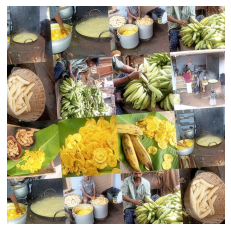

Question : What kind of food is being prepared?
Top Predicted answers:  [('pizza', 9.669157), ('cake', 4.5448856), ('vegetables', 4.4712095), ('cheese', 3.6687102), ('carrots', 2.722223)]
****************************************************************************************************


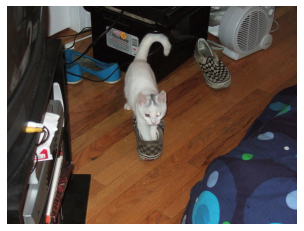

Question : Is the cat an adult?
Top Predicted answers:  [('no', 50.068634), ('yes', 49.7932), ('tie', 0.010702812), ('pillows', 0.008324269), ('collar', 0.007353123)]
****************************************************************************************************


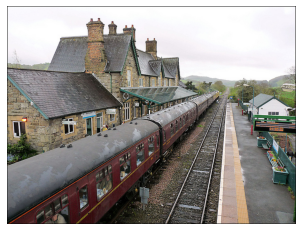

Question : What are the buildings on the left made of?
Top Predicted answers:  [('stop', 3.6447089), ('bus', 3.2030332), ('train', 2.8416655), ('street', 1.5591943), ('parking', 1.4908694)]
****************************************************************************************************


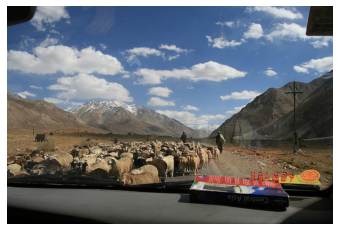

Question : How many herders can be seen?
Top Predicted answers:  [('very', 16.034588), ('2 feet', 6.071336), ('small', 6.0151143), ('10 feet', 5.660978), ('very tall', 5.3896217)]
****************************************************************************************************


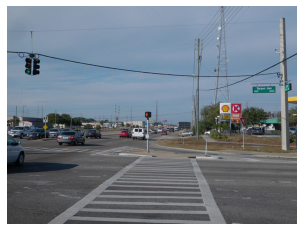

Question : What is the signal on the crosswalk light?
Top Predicted answers:  [('stop', 9.133996), ('train', 2.528311), ('brick', 2.5185173), ('bus', 2.0953581), ('double decker', 1.9582384)]
****************************************************************************************************


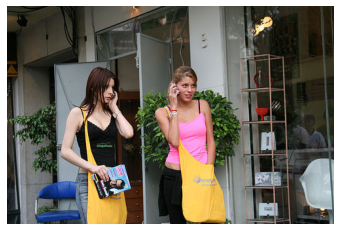

Question : What is the girl holding?
Top Predicted answers:  [('phone', 6.2213097), ('happy', 5.812103), ('fork', 2.3870566), ('donut', 2.1416118), ('yes', 2.0653958)]
****************************************************************************************************


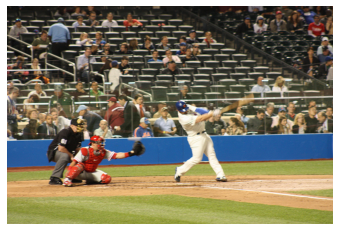

Question : Is this a professional game?
Top Predicted answers:  [('yes', 57.4427), ('no', 42.535877), ('1', 0.0046079713), ('baseball', 0.0020016753), ('red', 0.0018607858)]
****************************************************************************************************


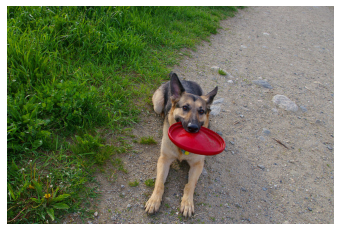

Question : What is the red object that the dogs are sitting near?
Top Predicted answers:  [('fence', 4.413563), ('yes', 3.7707899), ('no', 3.1780179), ('grass', 3.010895), ('eating', 2.3845754)]
****************************************************************************************************


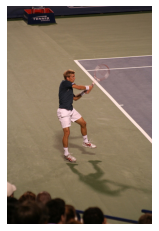

Question : Has he hit the ball yet?
Top Predicted answers:  [('yes', 58.356976), ('no', 41.57612), ('1', 0.013537951), ('baseball', 0.008624264), ('0', 0.004980395)]
****************************************************************************************************


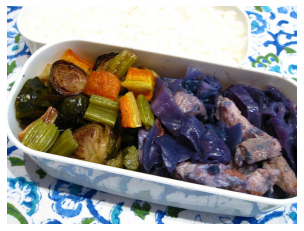

Question : What pattern is on the tablecloth?
Top Predicted answers:  [('yes', 3.6094167), ('no', 2.8063939), ('eating', 2.3188262), ('good', 2.1520324), ('food', 1.9536409)]
****************************************************************************************************


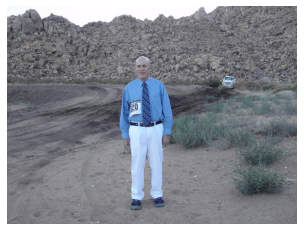

Question : Is the man wearing a tie or not?
Top Predicted answers:  [('skiing', 9.955362), ('safety', 9.487464), ('surfing', 6.413126), ('balance', 6.35027), ('protection', 5.9043083)]
****************************************************************************************************


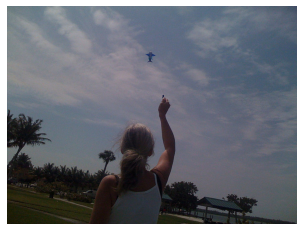

Question : Is the girl smiling?
Top Predicted answers:  [('no', 50.72243), ('yes', 48.84906), ('1', 0.03269743), ('surfing', 0.031669926), ('surfboard', 0.029722385)]
****************************************************************************************************


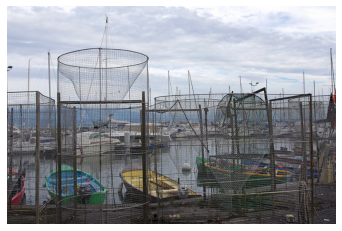

Question : Is this at a zoo?
Top Predicted answers:  [('no', 51.618282), ('yes', 48.302742), ('closed', 0.005477148), ('1', 0.0039141136), ('carpet', 0.0036480941)]
****************************************************************************************************


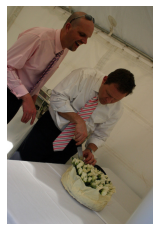

Question : How healthy is this food?
Top Predicted answers:  [('birthday', 8.789514), ('happy', 5.7772217), ('hungry', 4.4347763), ('eating', 3.7655327), ('wedding', 3.0267785)]
****************************************************************************************************


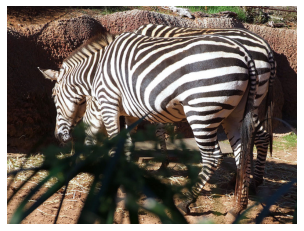

Question : Is there a tongue showing?
Top Predicted answers:  [('yes', 51.936237), ('no', 48.04423), ('collar', 0.0013937117), ('farm', 0.0011438631), ('giraffe', 0.0010197535)]
****************************************************************************************************


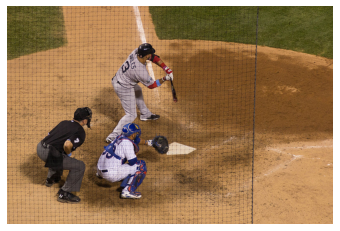

Question : What color is the man's helmet?
Top Predicted answers:  [('white', 18.277887), ('blue', 14.053047), ('green', 13.818232), ('red', 13.054827), ('yellow', 12.182591)]
****************************************************************************************************


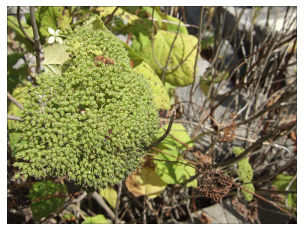

Question : Are these plants outside?
Top Predicted answers:  [('yes', 53.47979), ('no', 46.4385), ('eating', 0.007564715), ('farm', 0.0057751862), ('black and white', 0.0051349406)]
****************************************************************************************************


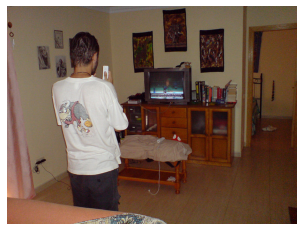

Question : What video-game console is being played here?
Top Predicted answers:  [('wii', 6.448339), ('hat', 5.20709), ('glasses', 3.547038), ('tie', 3.5338666), ('phone', 2.5645244)]
****************************************************************************************************


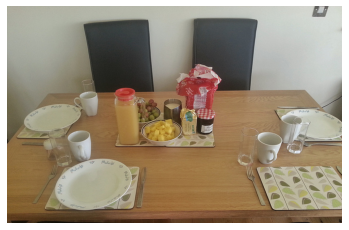

Question : Is this an appropriate meal for dinner?
Top Predicted answers:  [('yes', 52.580143), ('no', 47.397217), ('1', 0.0034660243), ('0', 0.0019583877), ('cake', 0.0017995461)]
****************************************************************************************************


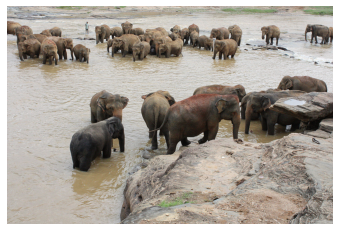

Question : How many people are in this picture?
Top Predicted answers:  [('very', 17.367088), ('2 feet', 12.536134), ('shallow', 8.706225), ('very tall', 5.940225), ('10 feet', 5.863405)]
****************************************************************************************************


In [29]:
generate_on_test(model)

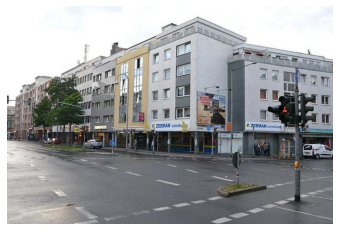

Question : is the street busy?
Actual Answer:  no
Top Predicted answers:  [('yes', 53.087173), ('no', 46.89976), ('1', 0.0016663187), ('closed', 0.001154953), ('moving', 0.000883539)]
****************************************************************************************************


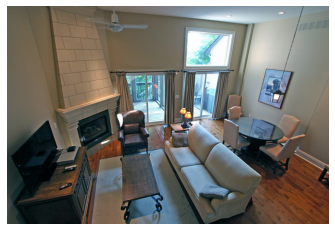

Question : is this a tall room?
Actual Answer:  yes
Top Predicted answers:  [('no', 50.031334), ('yes', 49.9604), ('pillows', 0.001616918), ('closed', 0.00074480835), ('1', 0.00043124292)]
****************************************************************************************************


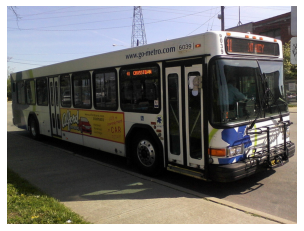

Question : how many people on the bus?
Actual Answer:  0
Top Predicted answers:  [('2', 27.679428), ('1', 25.958288), ('3', 12.940092), ('0', 8.959073), ('4', 8.216566)]
****************************************************************************************************


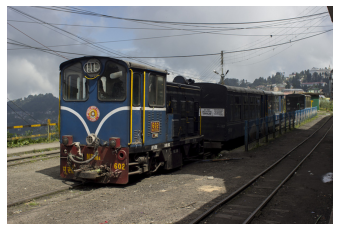

Question : how old is the train in the picture?
Actual Answer:  old
Top Predicted answers:  [('2', 10.429601), ('1', 9.546416), ('3', 7.9561567), ('0', 7.235363), ('4', 6.0266876)]
****************************************************************************************************


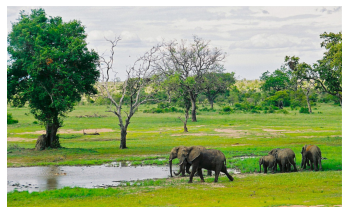

Question : could this be a watering hole?
Actual Answer:  yes
Top Predicted answers:  [('yes', 51.067936), ('no', 48.925), ('farm', 0.0011983558), ('giraffe', 0.00064499327), ('closed', 0.00037824665)]
****************************************************************************************************


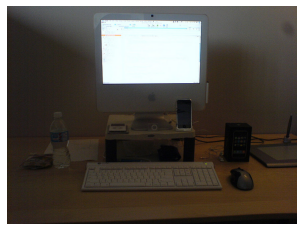

Question : how many screens are there?
Actual Answer:  1
Top Predicted answers:  [('1', 40.351334), ('2', 31.29309), ('0', 12.152327), ('3', 7.6935925), ('4', 5.097716)]
****************************************************************************************************


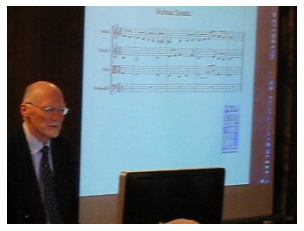

Question : is the room dark?
Actual Answer:  yes
Top Predicted answers:  [('yes', 50.679485), ('no', 49.31207), ('bathroom', 0.0010100945), ('1', 0.0008934504), ('out', 0.00038786203)]
****************************************************************************************************


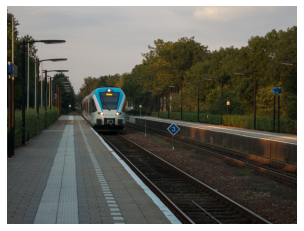

Question : how many tracks?
Actual Answer:  2
Top Predicted answers:  [('2', 23.09699), ('1', 22.069422), ('3', 13.201097), ('0', 9.541473), ('4', 8.79287)]
****************************************************************************************************


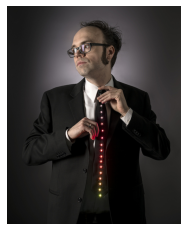

Question : are more than 2 buttons visible?
Actual Answer:  yes
Top Predicted answers:  [('yes', 51.8493), ('no', 48.14735), ('1', 0.00054848625), ('pillows', 0.00038442132), ('closed', 0.0002872102)]
****************************************************************************************************


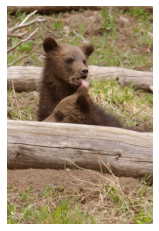

Question : is the bear thirsty?
Actual Answer:  yes
Top Predicted answers:  [('yes', 53.557438), ('no', 46.433517), ('farm', 0.0010100623), ('1', 0.00065392384), ('closed', 0.00043594046)]
****************************************************************************************************


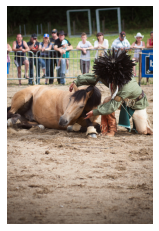

Question : what is the man doing?
Actual Answer:  petting horse
Top Predicted answers:  [('skateboarding', 16.218422), ('standing', 11.308999), ('walking', 9.054942), ('sitting', 8.92283), ('talking on phone', 4.838951)]
****************************************************************************************************


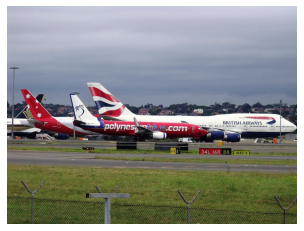

Question : how many airplanes are visible?
Actual Answer:  4
Top Predicted answers:  [('2', 25.397528), ('1', 22.243244), ('3', 13.952758), ('4', 8.758433), ('0', 7.362784)]
****************************************************************************************************


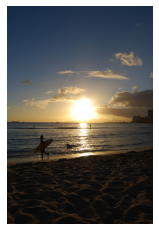

Question : what time of day is it?
Actual Answer:  evening
Top Predicted answers:  [('afternoon', 27.968927), ('noon', 17.03684), ('evening', 12.950442), ('morning', 6.7346454), ('daytime', 5.8885045)]
****************************************************************************************************


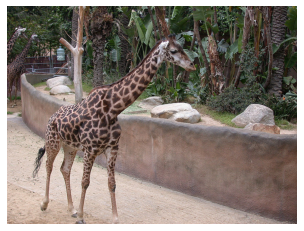

Question : how many giraffes are there?
Actual Answer:  3
Top Predicted answers:  [('2', 35.151478), ('1', 31.118006), ('3', 13.1960945), ('0', 6.862198), ('4', 6.5991855)]
****************************************************************************************************


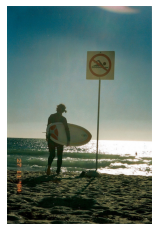

Question : how many surfboards are pictured?
Actual Answer:  1
Top Predicted answers:  [('1', 33.888634), ('2', 33.776302), ('3', 11.149231), ('0', 7.5162215), ('4', 6.4508276)]
****************************************************************************************************


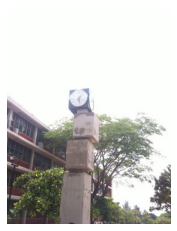

Question : is the clock going to fall?
Actual Answer:  no
Top Predicted answers:  [('no', 51.902737), ('yes', 48.091377), ('pillows', 0.0010956024), ('closed', 0.0005815156), ('giraffe', 0.00037836187)]
****************************************************************************************************


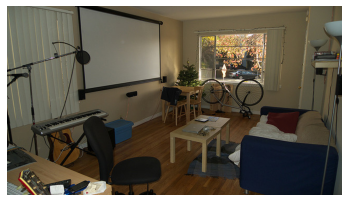

Question : what is in the window?
Actual Answer:  tree
Top Predicted answers:  [('nothing', 5.119199), ('laptop', 3.3568873), ('tv', 3.2021244), ('table', 2.5159771), ('microwave', 2.2314014)]
****************************************************************************************************


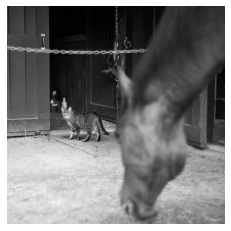

Question : is the dog comfortable?
Actual Answer:  no
Top Predicted answers:  [('yes', 54.007904), ('no', 45.986576), ('cake', 0.0004916976), ('1', 0.00048007932), ('red', 0.0003344116)]
****************************************************************************************************


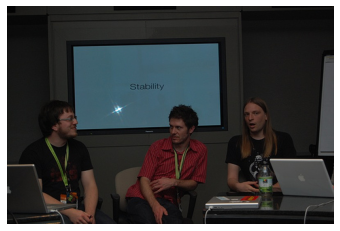

Question : how many people in the picture?
Actual Answer:  3
Top Predicted answers:  [('1', 33.38685), ('2', 32.0307), ('3', 10.809962), ('0', 9.326331), ('4', 6.679797)]
****************************************************************************************************


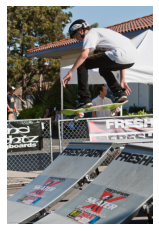

Question : what sport is this?
Actual Answer:  skateboarding
Top Predicted answers:  [('tennis', 47.012447), ('baseball', 21.839022), ('skateboarding', 14.622353), ('soccer', 4.5841293), ('frisbee', 2.7941763)]
****************************************************************************************************


In [30]:
generate_on_val(model)

In [31]:
print_accuracy_metrics(model)

0it [00:00, ?it/s]

(32, 24, 256) (32, 24, 256) (32, 24, 256)
Tensor("model/coattention_model/MatMul_3:0", shape=(32, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(32, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(32, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(32, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(32, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_14:0", shape=(32, 1, 256), dtype=float32)


3349it [12:42,  3.59it/s]

(None, 24, 256) (None, 24, 256) (None, 24, 256)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 256), dtype=float32)
Tensor("model/coattention_model/MatMul_14:0", shape=(None, 1, 256), dtype=float32)


3350it [12:44,  4.38it/s]
214349it [00:49, 4303.45it/s]


Accuracy : 38.91457389584225
